In [45]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import uuid

In [46]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
# from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc
from matplotlib import pyplot as plt


In [102]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

def state_init_bell_pairs_explicitCNOT(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=1/4))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
    qc.Add_Gate(Quantum_Gate("AZ",0,angle=(-1/20)))


def state_init_bell_pairs_explicitCNOT_withXXerror(qc,n,XXangle):
    # angle_error=arccos(math.sqrt(XXerror))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=XXangle[i]))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            pass
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
    if (clifford=="XX"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("FTXA",2*i,2*i+1,angle=1/4))

def add_clifford_layer_withXXerror(qc,n,clifford,XXangle):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
    if (clifford=="XX"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("FTXA",2*i,2*i+1,angle=XXangle))
            
def bell_measurement(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
        
def bell_measurement_explicitCNOT(qc,n):
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=1/4))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def bell_measurement_explicitCNOT_withXXerror(qc,n,XXangle):
    # scale_for_angle=XXerror
    for i in range (n):
#         qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=0.5))
        qc.Add_Gate(Quantum_Gate("FTXA",i,int(i+n),angle=XXangle[i]))
        qc.Add_Gate(Quantum_Gate("SKAY",i,angle=-0.5))
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=-0.5))
        qc.Add_Gate(Quantum_Gate("AZ",i,angle=(-1/2)))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

def add_XX_clifford(circ,index):
    circ.z(2*index)
    circ.h(2*index)
    circ.x(2*index)
    circ.z(2*index)
    circ.cx(2*index,2*index+1)
    circ.s(2*index)
    circ.h(2*index)
    circ.x(2*index)
    circ.h(2*index+1)
    circ.s(2*index+1)
    circ.h(2*index+1)
        
    
    

In [103]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

# read in calibration file


{'xx34': ['0.45925', '0.50025', '0.49875', '0.51675', '0.513', '0.5', '0.497', '0.49025', '0.46575', '0.4845', '0.492', '0.48025', '0.5225', '0.5015', '0.47125', '0.4955', '0.50725', '0.4915', '0.505', '0.39175', '0.4985', '0.50275', '0.522', '0.4865', '0.49', '0.496', '0.49825', '0.5075', '0.4905', '0.4915', '0.615', '0.48425', '0.51075', '0.612', '0.49925', '0.4795', '0.495', '0.4925'], 'xx23': ['0.47825', '0.50175', '0.45675', '0.50625', '0.5', '0.4935', '0.522', '0.448', '0.527', '0.5275', '0.5185', '0.4945', '0.49125', '0.55975', '0.50425', '0.49425', '0.46725', '0.51775', '0.49425', '0.49425', '0.48125', '0.518', '0.4445', '0.4995', '0.51', '0.4705', '0.5015', '0.49275', '0.499', '0.4985', '0.49', '0.45875', '0.50675', '0.492', '0.51025', '0.51225', '0.55', '0.5115'], 'xx25': ['0.4115\n', '0.5145\n', '0.4905\n', '0.52675\n', '0.50875\n', '0.508\n', '0.49525\n', '0.46025\n', '0.5115\n', '0.486\n', '0.51\n', '0.4875\n', '0.49275\n', '0.53925\n', '0.511\n', '0.51125\n', '0.472\n', '

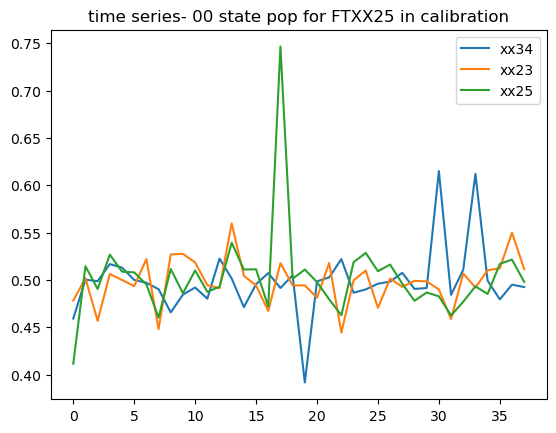

In [104]:
import os
pop00={}
# pop00_xx23=[]
# pop00_xx34=[]
# pop00_xx25=[]
gates=["xx34","xx23","xx25"] # in the same order as shown in the calibration file
for gate in gates:
        pop00[gate]=[]
i=0
dirname="/Users/yzhu/yzhu_work/gates projects/EAB/data/FTXX EAB 01162024/calibration/"
for file in os.listdir(dirname):
        if file!=".DS_Store" and file!="archive":
                with open(dirname+file, 'r') as f: 
                        lines=f.readlines()
                        temp_line_list=lines[1].split("\t")
                        if len(temp_line_list)==3:
                                for i in (range(len(temp_line_list))):
                                        pop00[gates[i]].append(temp_line_list[i])
                                        
                                
                       
                                
print (pop00)
plt.plot(range(len(pop00["xx34"])),[float(x) for x in pop00["xx34"]])
plt.title("time series- 00 state pop for FTXX34 in calibration")

plt.plot(range(len(pop00["xx23"])),[float(x) for x in pop00["xx23"]])
plt.title("time series- 00 state pop for FTXX23 in calibration")

plt.plot(range(len(pop00["xx25"])),[float(x) for x in pop00["xx25"]])
plt.title("time series- 00 state pop for FTXX25 in calibration")
plt.legend(gates)

In [105]:
print (len(pop00["xx23"]))
print (len(pop00["xx34"]))
print (len(pop00["xx25"]))

38
38
38


# Stochastic amplitude fluctuation
##### for each circuit, randomly draw amplitude from respective time time series to use for the XX gates in state prep and measurement. It will be the same amplitude used in the same circuit in both bell state prep and bell state measurement for the same gate.
##### The XX angle with noise is theta*(arccos(sqrt(pop00_calibartion)))/(pi/4)


In [124]:
# #define error model parameters

# import math
# from math import pi
# from qiskit.quantum_info import Statevector
# from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
#     pauli_error, depolarizing_error, thermal_relaxation_error)

# #basic t2 error model
# # T1 and T2 values for qubit
# T1 = 1000000000000
# T2 = 1000000000000

# # Error probabilities
# # prob_1 = 0.001  # 1-qubit gate
# prob_2 = 0.03   # 2-qubit gate
 
# # Depolarizing quantum errors
# # error_1 = noise.depolarizing_error(prob_1, 1)
# error_2 = depolarizing_error(prob_2, 2)


In [133]:
Set_Mapping([2,3,5,4,1])
nqubit=2
# ancillae=2
S=Quantum_Circuit(2*nqubit,"qc")
S_explicit=Quantum_Circuit(2*nqubit,"qc_e")
total_depth=5
depth=[2**x for x in range(1,total_depth+1)] #depth for Concatenation
C=20 #number of samples per depth

all_circuits=[]#a list of lists. circuits for all depths. each element is a list of circuit of a certain depth d.
all_circuits_explicit=[]
circuits=[] #a list of circuits with a certain depth d
circuits_explicit=[]
eab_data=[] #a list of dictionaries. Each dictionary is the results and relevant info of one circuit
results={}

clifford_layer="XX"
#for qiskit 
backend = AerSimulator()
# t_echo=0

repeat= 5 # how many circuits before new amplitude is drawn 
repeat_curr=0
for d in depth:
    print ("\nDepth = %d"%d)
    print ("Number of samples = %d"%C)
    # time_delay= (300+80)*d*1000 #in ns
    # noise_model = NoiseModel()
    # errors_delay = [thermal_relaxation_error(T1, T2, time_delay)]*nqubit
    # for j in range (nqubit):
    #     noise_model.add_quantum_error(errors_delay[j], "delay",[nqubit+j])
    # for j in range (nqubit):
    #     noise_model.add_quantum_error(error_2, "cx",[j,j+nqubit])
    for i in range (C):
#generate XX angles for the two XX gates in state prep and measurement for this circuit
        if (repeat_curr==0):
            r=random.randint(0, (len(pop00["xx34"]))-1)
            XXangle1= np.arccos(math.sqrt(float(pop00["xx25"][r])))
            XXangle2= np.arccos(math.sqrt(float(pop00["xx34"][r])))
            XXangle=[XXangle1,XXangle2] #for state prep
            XXangle3=np.arccos(math.sqrt(float(pop00["xx23"][r])))
            repeat_curr+=1
        elif (repeat_curr > repeat-1):
            repeat_curr=0
            r=random.randint(0, (len(pop00["xx34"]))-1)
            XXangle1= np.arccos(math.sqrt(float(pop00["xx25"][r])))
            XXangle2= np.arccos(math.sqrt(float(pop00["xx34"][r])))
            XXangle=[XXangle1,XXangle2] #for state prep
            XXangle3=np.arccos(math.sqrt(float(pop00["xx23"][r])))
            repeat_curr+=1
        else: 
            repeat_curr+=1
        
        # print (XXangle)
#gates circuitt
        S.depth=0
        S.gates=[]
#gates explicit cnot circuit    
        S_explicit.depth=0
        S_explicit.gates=[]

#qiskit_circ=QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_state = QuantumCircuit(2*nqubit,2*nqubit)
        qiskit_c_gates = QuantumCircuit(nqubit)

        # #gates circuit state prep
        # state_init_bell_pairs(S,nqubit)
        #gates explicit CNOT circuit state prep
        state_init_bell_pairs_explicitCNOT_withXXerror(S_explicit,nqubit,XXangle)
        # qiskit circuit state prep
        for j in range(nqubit):
            prepare_bell_state_1q(qiskit_c_state,j,j+nqubit)
        qiskit_c_state.barrier()

        
        for j in range(d):
            #gates circuit add pauli layer
            # layer=add_pauli_twirl(S,nqubit)
            #gates explicit cnot circuit add pauli layer
            layer=add_pauli_twirl(S_explicit,nqubit)
            
            #qiskit circuit add pauli layer
            for q in range(nqubit):
                pauli_gate_1q(qiskit_c_gates,q,pauli=layer[q])


            # #gates circuit add clifford layer
            # add_clifford_layer(S,nqubit,clifford_layer)
            #gates explicit cnot circuit add clifford layer
            add_clifford_layer_withXXerror(S_explicit,nqubit,clifford_layer,XXangle3)
          
            #qiskit circuit add clifford layer
            if clifford_layer == 'Id':
                pass
            elif clifford_layer == 'CNOT':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    qiskit_c_gates.cx(2*q,2*q+1)
            elif clifford_layer == 'XX':
                ngates = int(nqubit/2)
                for q in range(ngates):
                    add_XX_clifford(qiskit_c_gates,q)
            qiskit_c_gates.barrier()
            
        #gates circuit add Pauli twirl
        # layer=add_pauli_twirl(S,nqubit)
        #gates explicit cnot circuit add Pauli twirl
        layer=add_pauli_twirl(S_explicit,nqubit)
        #qiskit circuit add Pauli twirl
        for j in range(nqubit):
            pauli_gate_1q(qiskit_c_gates,j,pauli=layer[j])
            #save the stablizer representation
        cliffordOp = Clifford(qiskit_c_gates)

        
        #for qiskit: append gates to state
        qiskit_circ = qiskit_c_state.compose(qiskit_c_gates,range(nqubit))

        # add dephasing noise to ancilla qubits
        # for j in range (nqubit,2*nqubit):
        #     qiskit_circ.delay(time_delay,unit="ns",qarg=j)
        
        # #gates circuti bell measurement
        # bell_measurement(S,nqubit)
        #gates explicit cnot circuti bell measurement
        bell_measurement_explicitCNOT_withXXerror(S_explicit,nqubit,XXangle)
        
        #qiskit circuti bell measurement
        for j in range(nqubit):
            bell_measurement_1q(qiskit_circ,j,j+nqubit)
        qiskit_circ.barrier(range(2*nqubit))
        qiskit_circ.measure(range(2*nqubit),range(2*nqubit))
        
        # qiskit_circ.draw('mpl')

#         #for qiskit 
        qc_compiled = transpile(qiskit_circ, backend)
        job_sim = backend.run(qc_compiled, shots=2000)
        result_sim = job_sim.result()
        counts_qiskit = result_sim.get_counts(qc_compiled)

                   
#         #package and format results
        results["n"]=nqubit
        results["L"]=d
        results["clifford"] = cliffordOp.to_dict()
        results["clifford_layer"] = clifford_layer
# #         statef=S.Simulate()
        statef=S_explicit.Simulate()
        counts=[round(2000*x) for x in statef.population]
        
        counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
        results["counts"]=counts_ibm_mapping_dic
        eab_data.append(results)

        results={}


# filename = str(uuid.uuid4())
# filename+="XX13452noS_explicitCNOT_FT_0516"
# with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/"+filename, "wb") as fp:
#     pickle.dump(eab_data, fp)



Depth = 2
Number of samples = 20

Depth = 4
Number of samples = 20

Depth = 8
Number of samples = 20

Depth = 16
Number of samples = 20

Depth = 32
Number of samples = 20


In [134]:
# qiskit_circ.draw('mpl')

In [135]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
'''Specify a set of Pauli you want to estimate'''
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB(depth, eab_data, pauli_request_list)

print (eab_result)

{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [1.0, 1.0, 0.974, 0.974, 0.974, 0.95, 1.0, 0.9500249875062469, 0.949, 0.999000499750125, 1.0, 1.0, 0.8139069534767384, 0.814, 0.814, 1.0, 0.987, 0.751, 1.0, 0.751], 4: [0.997, 1.0, 0.997, 0.766, 0.997, 0.915, 0.915, 0.9310344827586207, 0.915, 0.932, 0.876, 1.0, 1.0, 0.876, 0.876, 0.906, 0.906, 1.0, 1.0, 1.0], 8: [0.955, 0.947, 0.9919959979989995, 0.991, 0.955, 0.873, 0.936, 0.963, 0.863, 0.99, 0.997, 0.979, 0.9549774887443722, 0.944

In [136]:
raw_fidelity_list = eab_result["fidelity_list"]


# sys.exit(0)

fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)
print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))


Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.021961164328182292
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0006028883359574522 0.000542404203758299
YI 0.04801382226601181 0.008731112639565539
ZI 0.04710233025567001 0.009703598453611765
IX -0.0006355367005115298 0.0005122722752792024
XX -0.0002405782859136174 0.0007830464454666296
YX 0.04018417605461955 0.009425401993903194
ZX 0.04066221269962378 0.009976537890137006
IY 0.04801382226601181 0.008731112639565539
XY 0.04710233025567001 0.009703598453611765
YY 0.0 inf
ZY 0.0006028883359574522 0.000542404203758299
IZ 0.04018417605461955 0.009425401993903194
XZ 0.04066221269962378 0.009976537890137006
YZ -0.0006355367005115298 0.0005122722752792024
ZZ -0.0002405782859136174 0.0007830464454666296


In [113]:
# np.save("IdwithStoAmpNoise_sim_EAB_freq_everycircuit",[1-fidelity_list[pauli_label] for pauli_label in pauli_request_list])

In [99]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])

Label / Pauli error rates
II 1.0015603020987096
XI 1.3877787807814457e-17
YI -0.0012425367322993486
ZI 0.0
IX 1.3877787807814457e-17
XX 1.3877787807814457e-17
YX 0.0
ZX 0.0
IY -0.00024050402135619708
XY 1.3877787807814457e-17
YY -7.726134505414706e-05
ZY 0.0
IZ 4.163336342344337e-17
XZ 1.3877787807814457e-17
YZ 0.0
ZZ 0.0


In [68]:
# True value for this specific noise model
# eps=0
# def f_true(P):
#     ans = 0.0
#     for Pi in P:
#         if Pi == 'Z' or Pi == 'Y':
#             ans += 2*eps
#     return ans
# def p_true(P):
#     if P == "XI" or P == "IX":
#         return eps
#     else:
#         return 0.0

# print("Label / True infidelity/ True Pauli error")
# for P in pauli_request_list:
#     print(P[::-1]," ",f_true(P)," ",p_true(P))

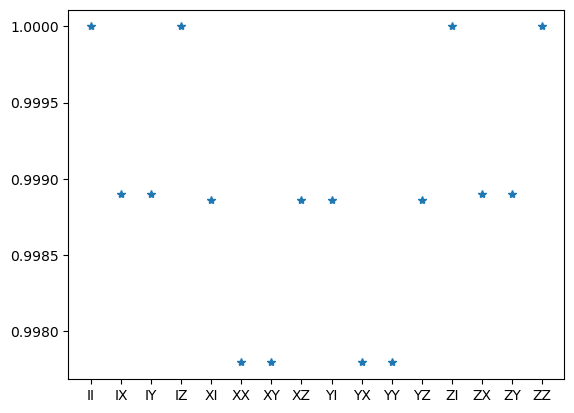

In [14]:
plt.plot([pauli_label for pauli_label in pauli_request_list],[fidelity_list[pauli_label] for pauli_label in pauli_request_list],"*")

# This noise is generating unphsical results: negative pauli infidelity